In [2]:
import os

import numpy as np
import pandas as pd
import polars as pl

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import catboost as cb
import xgboost as xgb


In [3]:
root = os.getcwd()
data_root = ""
print(root)
if root.startswith("/kaggle"):
    print("True")
    # Running on kaggle notebook
    data_root  = "/kaggle/input/isic-2024-challenge/"
else:
    data_root = "isic-2024-challenge/"

/home/charles/mc-it/sml/SML-A3


In [4]:

train_path =  data_root + 'train-metadata.csv'
test_path = data_root + "test-metadata.csv"
subm_path = data_root + "sample_submission.csv"

id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        
    'clin_size_long_diam_mm',            
    'tbp_lv_A',                          
    'tbp_lv_Aext',                      
    'tbp_lv_B',                          
    'tbp_lv_Bext',                   
    'tbp_lv_C',                         
    'tbp_lv_Cext',                      
    'tbp_lv_H',                         
    'tbp_lv_Hext',                      
    'tbp_lv_L',                         
    'tbp_lv_Lext',                      
    'tbp_lv_areaMM2',                    
    'tbp_lv_area_perim_ratio',           
    'tbp_lv_color_std_mean',             
    'tbp_lv_deltaA',                     
    'tbp_lv_deltaB',                     
    'tbp_lv_deltaL',                     
    'tbp_lv_deltaLB',                    
    'tbp_lv_deltaLBnorm',               
    'tbp_lv_eccentricity',               
    'tbp_lv_minorAxisMM',                
    'tbp_lv_nevi_confidence',           
    'tbp_lv_norm_border',               
    'tbp_lv_norm_color',                
    'tbp_lv_perimeterMM',                
    'tbp_lv_radial_color_std_max',      
    'tbp_lv_stdL',                      
    'tbp_lv_stdLExt',                    
    'tbp_lv_symm_2axis',                 
    'tbp_lv_symm_2axis_angle',           
    'tbp_lv_x',                         
    'tbp_lv_y',                          
    'tbp_lv_z',                          
]
new_num_cols = [

    
]
cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols ]
special_cols = ['count_per_patient']
feature_cols = num_cols + cat_cols + norm_cols + special_cols

In [5]:
def read_data(path):
    return (
        pl.read_csv(path)
        # Cast age_approx to float, replace 'NA' with NaN, and then cast to float
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()),
        )
        # Feature engineering
        .with_columns(
            # Using Polars' over function to calculate the mean and std for each patient
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        # Count the number of lesions per patient
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        # Cast categorical columns to categorical type
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )


In [6]:
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [7]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    print("partial_auc: ", partial_auc)

    
    return partial_auc

In [8]:
df_train = read_data(train_path)
df_test = read_data(test_path)
df_subm = pd.read_csv(subm_path, index_col=id_col)

df_train, df_test = preprocess(df_train, df_test)

In [9]:
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      seed,
    'learning_rate':     0.2, 
    'cat_features':      cat_cols,
}

cb_model = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=seed)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', cb.CatBoostClassifier(**cb_params)),
])

In [10]:
xgb_params = {
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       seed,
    'learning_rate':      0.08, 
}

xgb_model = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=seed)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', xgb.XGBClassifier(**xgb_params)),
])

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 6,
    'random_state': seed,
    'verbose': -1,
}

lgb_model = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=seed)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', lgb.LGBMClassifier(**lgb_params)),
])


In [11]:
estimator = VotingClassifier([
    ('lgb', lgb_model), ('cb', cb_model), ('xgb', xgb_model),
], voting='soft') 
# Create a stratified group K-fold cross-validation
from collections import defaultdict
from sklearn.base import clone
def stratified_group_k_fold(X, y, groups, n_splits=20, shuffle=True, random_state=None):
    # Create a dictionary mapping groups to their indices
    group_dict = defaultdict(list)
    for idx, group in enumerate(groups):
        group_dict[group].append(idx)

    # Randomize the groups
    if shuffle:
        rng = np.random.default_rng(random_state)
        group_keys = list(group_dict.keys())
        rng.shuffle(group_keys)
    else:
        group_keys = list(group_dict.keys())

    # Stratify by class
    unique_classes, class_counts = np.unique(y, return_counts=True)
    splits = [[] for _ in range(n_splits)]
    class_splits = {cls: [[] for _ in range(n_splits)] for cls in unique_classes}

    for cls in unique_classes:
        # Get all groups for the current class
        cls_indices = np.where(y == cls)[0]
        cls_groups = np.unique(groups[cls_indices])

        for group in cls_groups:
            group_indices = group_dict[group]   

            # Assign groups to different folds, ensuring uniform distribution of classes
            assigned_split = min(range(n_splits), key=lambda x: len(class_splits[cls][x]))
            class_splits[cls][assigned_split].extend(group_indices)
            splits[assigned_split].extend(group_indices)

    return splits


def custom_cross_val_score(estimator, X, y, groups, splits, scoring):
    scores = []
    for i, test_indices in enumerate(splits):
        train_indices = [idx for j, s in enumerate(splits) if j != i for idx in s]

        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

        # Clone the model to avoid changing the original model during training
        model = clone(estimator)
        model.fit(X_train, y_train)

        # Calculate the score
        score = scoring(model, X_test, y_test)
        scores.append(score)
    return scores

/tmp/ipykernel_2431/3296131715.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cls_groups = np.unique(groups[cls_indices])


partial_auc:  0.196044263165103
Precision: 0.6363636363636364
Recall: 0.65625
partial_auc:  0.18735284103786817
Precision: 0.7105263157894737
Recall: 0.7297297297297297
partial_auc:  0.1954008986343935
Precision: 0.8333333333333334
Recall: 0.6097560975609756
partial_auc:  0.1996768674432517
Precision: 0.7586206896551724
Recall: 0.6111111111111112
partial_auc:  0.19422243585003326
Precision: 0.723404255319149
Recall: 0.68
partial_auc:  0.19976237702761832
Precision: 0.6896551724137931
Recall: 0.6896551724137931
partial_auc:  0.19808864905242865
Precision: 0.7714285714285715
Recall: 0.6428571428571429
partial_auc:  0.19941910324062764
Precision: 0.7021276595744681
Recall: 0.7021276595744681
partial_auc:  0.19856522569261553
Precision: 0.6458333333333334
Recall: 0.7045454545454546
partial_auc:  0.19925222456491434
Precision: 0.7631578947368421
Recall: 0.725
partial_auc:  0.19755565255347007
Precision: 0.5862068965517241
Recall: 0.5666666666666667
partial_auc:  0.19856364641545443
Precisio

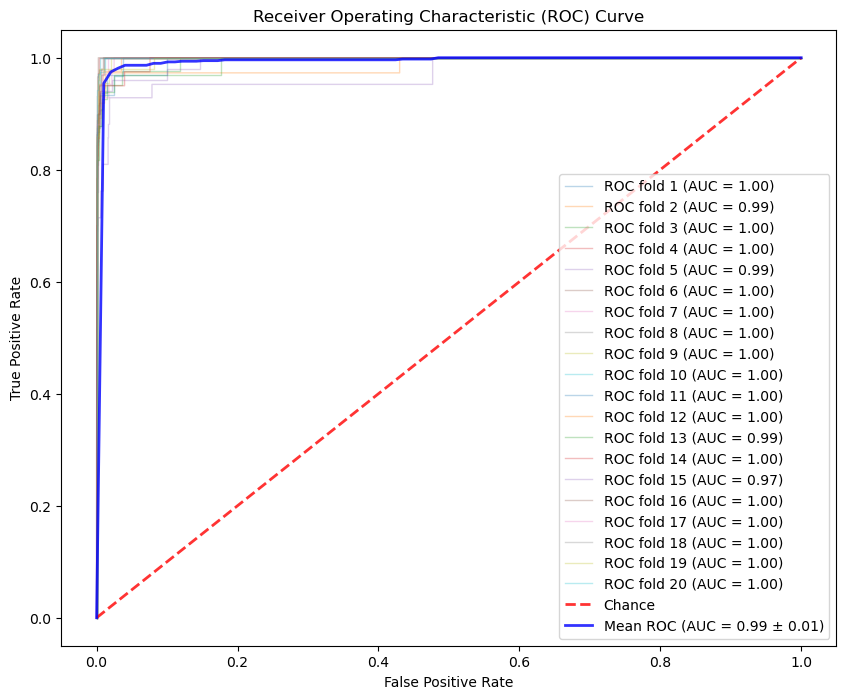

In [12]:
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt
import numpy as np

def custom_cross_val_score(estimator, X, y, groups, splits, scoring):
    scores = []
    all_fpr = []
    all_tpr = []
    recalls = []
    precisions = []
    for i, test_indices in enumerate(splits):
        
        train_indices = [idx for j, s in enumerate(splits) if j != i for idx in s]
        
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

        model = clone(estimator)
        model.fit(X_train, y_train)

        score = scoring(model, X_test, y_test)
        scores.append(score)

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)  # Predict the labels
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        recalls.append(recall_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        print(f"Precision: {precisions[-1]}")
        print(f"Recall: {recalls[-1]}")
    return scores, all_fpr, all_tpr, recalls, precisions

X = df_train[feature_cols]
y = df_train[target_col]
groups = df_train[group_col]

splits= stratified_group_k_fold(X, y, groups, n_splits=20, shuffle=True, random_state=seed)


val_score, all_fpr, all_tpr, recalls, precisions = custom_cross_val_score(
    estimator=estimator,
    X=X,
    y=y,
    groups=groups,
    splits=splits,  
    scoring=custom_metric,
)

mean_score = np.mean(val_score)
mean_recall = np.mean(recalls)
mean_precision = np.mean(precisions)
print(f"Mean pAucscore: {mean_score:.4f}")
print(f"Mean recall: {mean_recall:.4f}")

plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (fpr, tpr) in enumerate(zip(all_fpr, all_tpr)):
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # Using Numpy's interp function to interpolate the tpr values
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
X, y = df_train[feature_cols],   df_train[target_col]

estimator.fit(X, y)

VotingClassifier(estimators=[('lgb',
                              Pipeline(steps=[('sampler_1',
                                               RandomOverSampler(random_state=42,
                                                                 sampling_strategy=0.003)),
                                              ('sampler_2',
                                               RandomUnderSampler(random_state=42,
                                                                  sampling_strategy=0.01)),
                                              ('classifier',
                                               LGBMClassifier(learning_rate=0.05,
                                                              max_depth=6,
                                                              metric='auc',
                                                              objective='binary',
                                                              random_state=42,
                                                              verbose=-1))])),
                             ('cb',
                              Pipeline(steps=[('samp...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.08,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))]))],
                 voting='soft')

In [14]:
df_subm['target'] = estimator.predict_proba(df_test[feature_cols])[:, 1]

df_subm.to_csv('submission.csv')
df_subm.head()

,target
isic_id,
ISIC_0015657,0.687896
ISIC_0015729,0.331432
ISIC_0015740,0.865464


In [15]:
print(f"Mean precision: {mean_precision:.4f}")
print(recalls)
print(precisions)
print(val_score)

Mean precision: 0.7273
[0.65625, 0.7297297297297297, 0.6097560975609756, 0.6111111111111112, 0.68, 0.6896551724137931, 0.6428571428571429, 0.7021276595744681, 0.7045454545454546, 0.725, 0.5666666666666667, 0.6904761904761905, 0.48484848484848486, 0.6, 0.38095238095238093, 0.6326530612244898, 0.6470588235294118, 0.65625, 0.68, 0.6285714285714286]
[0.6363636363636364, 0.7105263157894737, 0.8333333333333334, 0.7586206896551724, 0.723404255319149, 0.6896551724137931, 0.7714285714285715, 0.7021276595744681, 0.6458333333333334, 0.7631578947368421, 0.5862068965517241, 0.7837837837837838, 0.6153846153846154, 0.7058823529411765, 0.6956521739130435, 0.8157894736842105, 0.6875, 0.7777777777777778, 0.8292682926829268, 0.8148148148148148]
[0.196044263165103, 0.18735284103786817, 0.1954008986343935, 0.1996768674432517, 0.19422243585003326, 0.19976237702761832, 0.19808864905242865, 0.19941910324062764, 0.19856522569261553, 0.19925222456491434, 0.19755565255347007, 0.19856364641545443, 0.1932598668187

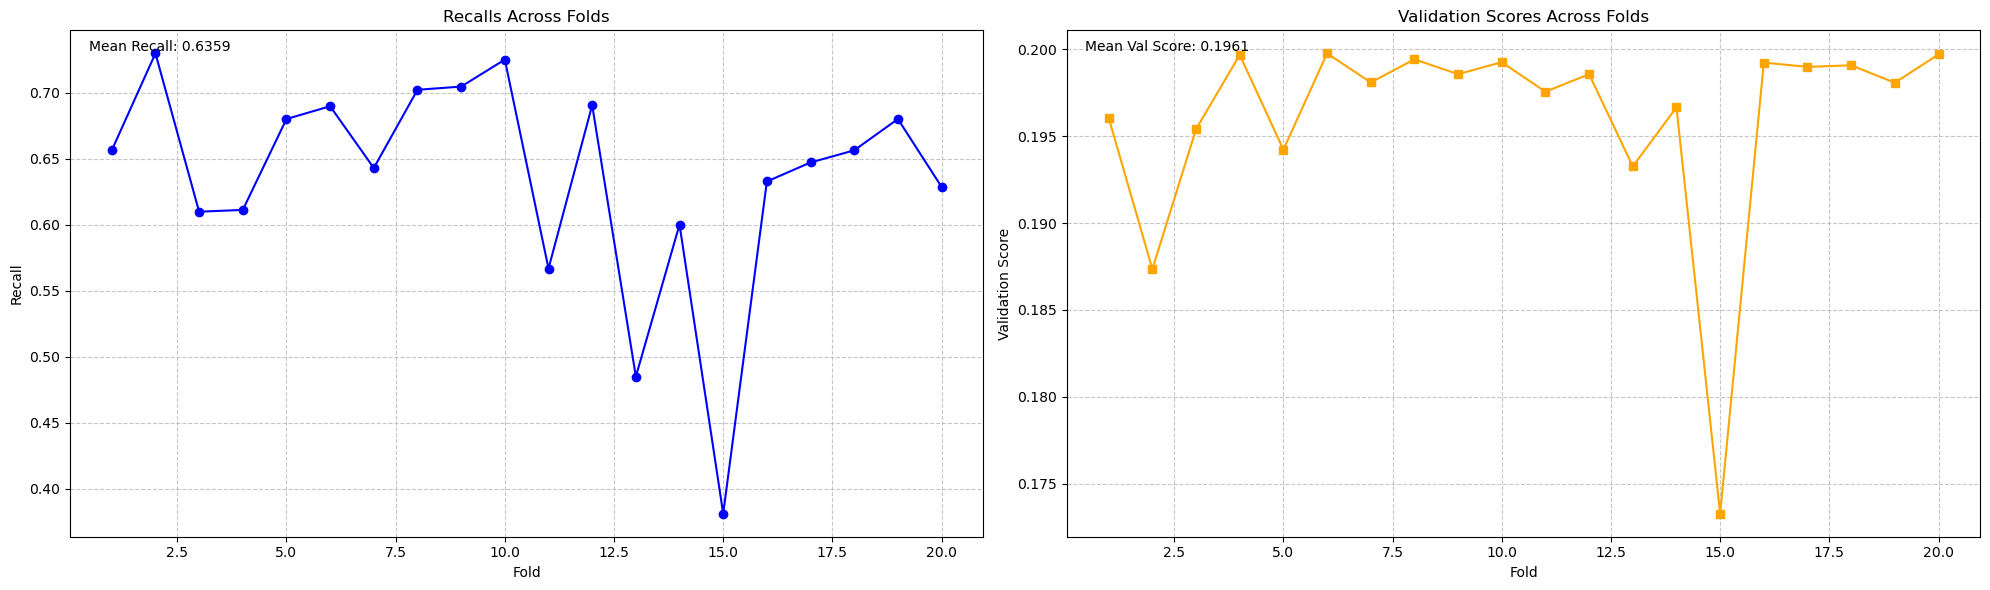

Recalls: [0.65625, 0.7297297297297297, 0.6097560975609756, 0.6111111111111112, 0.68, 0.6896551724137931, 0.6428571428571429, 0.7021276595744681, 0.7045454545454546, 0.725, 0.5666666666666667, 0.6904761904761905, 0.48484848484848486, 0.6, 0.38095238095238093, 0.6326530612244898, 0.6470588235294118, 0.65625, 0.68, 0.6285714285714286]
Val Scores: [0.196044263165103, 0.18735284103786817, 0.1954008986343935, 0.1996768674432517, 0.19422243585003326, 0.19976237702761832, 0.19808864905242865, 0.19941910324062764, 0.19856522569261553, 0.19925222456491434, 0.19755565255347007, 0.19856364641545443, 0.19325986681878654, 0.19665573223618363, 0.17328166206453705, 0.19923195327527396, 0.1989824314645911, 0.19907563985374763, 0.19807269653423495, 0.1997023209364407]


In [17]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot recalls
ax1.plot(range(1, len(recalls) + 1), recalls, marker='o', linestyle='-', color='blue')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Recall')
ax1.set_title('Recalls Across Folds')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.02, 0.98, f'Mean Recall: {np.mean(recalls):.4f}', transform=ax1.transAxes, verticalalignment='top')

# Plot val_scores
ax2.plot(range(1, len(val_score) + 1), val_score, marker='s', linestyle='-', color='orange')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Validation Score')
ax2.set_title('Validation Scores Across Folds')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.text(0.02, 0.98, f'Mean Val Score: {np.mean(val_score):.4f}', transform=ax2.transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Print out the values for reference
print("Recalls:", recalls)
print("Val Scores:", val_score)

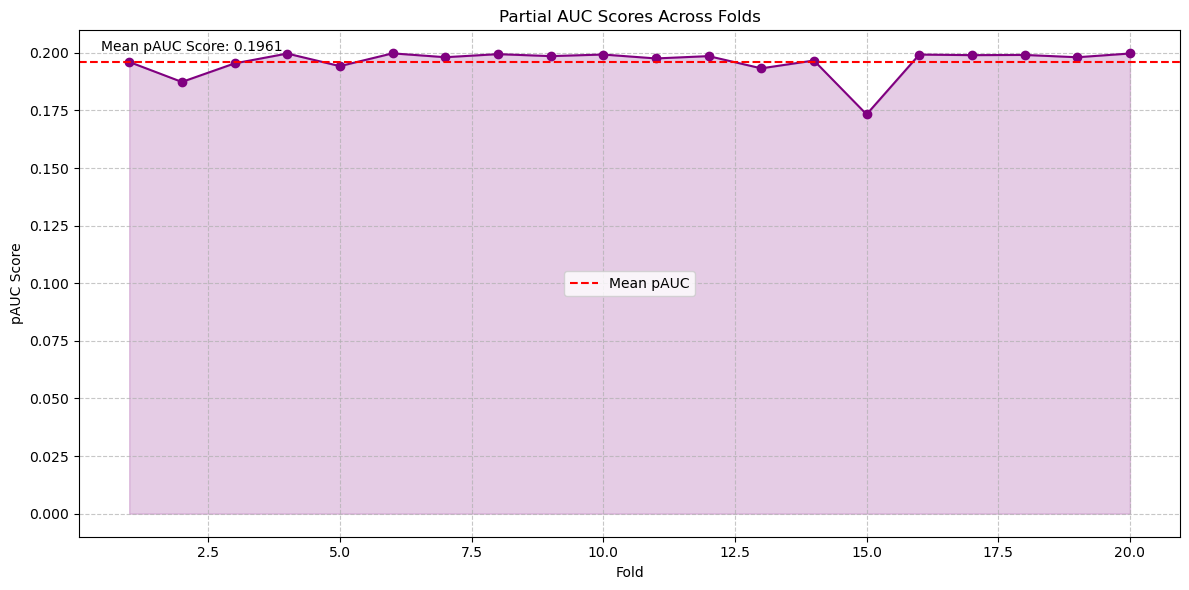

pAUC Scores: [0.196044263165103, 0.18735284103786817, 0.1954008986343935, 0.1996768674432517, 0.19422243585003326, 0.19976237702761832, 0.19808864905242865, 0.19941910324062764, 0.19856522569261553, 0.19925222456491434, 0.19755565255347007, 0.19856364641545443, 0.19325986681878654, 0.19665573223618363, 0.17328166206453705, 0.19923195327527396, 0.1989824314645911, 0.19907563985374763, 0.19807269653423495, 0.1997023209364407]
Mean pAUC Score: 0.1961


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming val_score contains your pAUC scores
pAUC_scores = val_score

plt.figure(figsize=(12, 6))

# Plot pAUC scores
plt.plot(range(1, len(pAUC_scores) + 1), pAUC_scores, marker='o', linestyle='-', color='purple')
plt.fill_between(range(1, len(pAUC_scores) + 1), pAUC_scores, alpha=0.2, color='purple')

plt.xlabel('Fold')
plt.ylabel('pAUC Score')
plt.title('Partial AUC Scores Across Folds')
plt.grid(True, linestyle='--', alpha=0.7)

# Add text annotation for mean pAUC score
mean_pAUC = np.mean(pAUC_scores)
plt.text(0.02, 0.98, f'Mean pAUC Score: {mean_pAUC:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal line for mean pAUC score
plt.axhline(y=mean_pAUC, color='r', linestyle='--', label='Mean pAUC')

plt.legend()
plt.tight_layout()
plt.show()

# Print out the values for reference
print("pAUC Scores:", pAUC_scores)
print(f"Mean pAUC Score: {mean_pAUC:.4f}")